<a href="https://colab.research.google.com/github/ankit-rathi/Data-Science-with-Python/blob/master/Tradevesting/myProspects_Buy_Sell_Signals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218908 sha256=e218337be0a1b1ba3c02fb085b315415d56ab1cf4b519ee4970a05e2ceac46d4
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

mypf = pd.read_csv('/content/drive/My Drive/data/stocks/myProspectsScrips.csv')

mypf = mypf[(mypf['Criteria'] == 'V40') | (mypf['Criteria'] == 'V40N')]

stock_n100 = mypf['Symbol'].unique()

exclude = ['CADILAHC','MMTC']

stock_n100 = mypf[~mypf['Symbol'].isin(exclude) ]['Symbol'].unique()

stock_ids = stock_n100

#mypf = mypf[mypf.Forecast.notnull()]
#stock_ids = mypf['Symbol'].unique()

stock_ids.sort()
#stock_ids

Mounted at /content/drive


In [3]:
# import necessary libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
#import talib
yfin.pdr_override()
import pandas_ta as ta

In [4]:
# function to compute stock attributes

def stock_prec_dev(stock_symbol, date):
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    end_date = date.strftime('%Y-%m-%d')
    start_date = (date + datetime.timedelta(days=-365*3)).strftime('%Y-%m-%d')
    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    #start = datetime.datetime(*map(int, start_date.split('-')))
    #end = datetime.datetime(*map(int, end_date.split('-')))
    stock_df = yfin.Ticker(stock_symbol).history(period='3y')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    #stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe
    #stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    mid_window_col = str(mid_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg

    #print(stock_df)

    # Create short exponential moving average column
    stock_df[short_window_col] = round(stock_df['Close'].rolling(window = short_window, min_periods = 1).mean(),0)

    stock_df[mid_window_col] = round(stock_df['Close'].rolling(window = mid_window, min_periods = 1).mean(),0)

    #stock_df['RSI'] = round(talib.RSI(stock_df['Close Price'], timeperiod=14),0)

    # Create a long exponential moving average column
    stock_df[long_window_col] = round(stock_df['Close'].rolling(window = long_window, min_periods = 1).mean(),0)
    stock_df['Stock'] = stock_symbol
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df['Close'] = round(stock_df['Close'],0)
    stock_df.drop(['Open', 'Low', 'High', 'Volume'
                   ], axis=1, inplace=True)

    return stock_df

def get_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal'])

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal'])

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)

    return df_pos.tail(1)

def get_daily_buy_sell():
    df_buy_sell = pd.DataFrame()
    for stock_id in stock_ids:
        df_tmp = get_stock_buy_sell(stock_id+'.NS')
        df_tmp['Criteria'] = mypf[(mypf['Symbol']) == stock_id.upper()]['Criteria'].values[0]
        df_buy_sell = df_buy_sell.append(df_tmp)


    df_buy_sell['Position'] = df_buy_sell['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
    return df_buy_sell.sort_index()

def plot_stock_buy_sell(stock_symbol):
    date = (datetime.date.today() + datetime.timedelta(days=0))
    df_prec_dev = stock_prec_dev(stock_symbol, date)
    df_prec_dev['Signal'] = 0.0
    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] < df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] < df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] < df_prec_dev['200_SMA'])), 1.0, df_prec_dev['Signal'])

    df_prec_dev['Signal'] = np.where(((df_prec_dev['Close'] > df_prec_dev['20_SMA']) & (df_prec_dev['20_SMA'] > df_prec_dev['50_SMA']) & (df_prec_dev['50_SMA'] > df_prec_dev['200_SMA'])), -1.0, df_prec_dev['Signal'])

    df_prec_dev['Position'] = df_prec_dev['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    df_prec_dev['Close'].plot(color = 'k', lw = 1, label = 'Close')
    #stock_df[short_window_col].plot(color = 'g', lw = 1, label = short_window_col)
    df_prec_dev['20_SMA'].plot(color = 'g', lw = 1, label = '20_SMA')
    df_prec_dev['50_SMA'].plot(color = 'm', lw = 1, label = '50_SMA')
    df_prec_dev['200_SMA'].plot(color = 'b', lw = 1, label = '200_SMA')

    df_pos = df_prec_dev[(df_prec_dev['Position'] >= 1) | (df_prec_dev['Position'] <= -1)]
    df_pos = df_pos[df_pos['Signal'] != 0]
    df_pos['Prev_Signal'] = df_pos['Signal'].shift(1)
    df_pos = df_pos[df_pos['Signal'] != df_pos['Prev_Signal']]
    df_pos.drop('Prev_Signal', axis=1, inplace=True)


    # plot 'buy' signals
    plt.plot(df_pos[df_pos['Position'] >= 1].index,
          df_pos['Close'][df_pos['Position'] >= 1],
          '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(df_pos[df_pos['Position'] <= -1].index,
          df_pos['Close'][df_pos['Position'] <= -1],
          'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')

    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(stock_symbol + '  : Buy/Sell Signal', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()

    display_table = True

    if display_table == True:
      print(stock_symbol)
      df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x >= 1 else 'Sell')
      print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

df_daily_buy_sell = get_daily_buy_sell()

In [5]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Sell'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position,Criteria
Date,,,,,,,,,
2022-09-12 00:00:00+05:30,1132.0,1012.0,957.0,955.0,RADICO.NS,18.54,-1.0,Sell,V40N
2022-09-20 00:00:00+05:30,475.0,461.0,435.0,433.0,FINCABLES.NS,9.72,-1.0,Sell,V40N
2022-09-23 00:00:00+05:30,2581.0,2544.0,2409.0,2403.0,POLYCAB.NS,7.40,-1.0,Sell,V40N
2022-11-11 00:00:00+05:30,1526.0,1437.0,1331.0,1329.0,MCX.NS,14.86,-1.0,Sell,V40N
2022-11-21 00:00:00+05:30,53.0,51.0,50.0,49.0,EQUITASBNK.NS,7.55,-1.0,Sell,V40N
2022-12-01 00:00:00+05:30,1107.0,1067.0,991.0,988.0,HCLTECH.NS,12.07,-1.0,Sell,V40
2023-02-06 00:00:00+05:30,966.0,965.0,936.0,922.0,SYMPHONY.NS,4.82,-1.0,Sell,V40N
2023-03-09 00:00:00+05:30,3031.0,2989.0,2923.0,2919.0,OFSS.NS,3.85,-1.0,Sell,V40N
2023-03-16 00:00:00+05:30,3800.0,3789.0,3750.0,3747.0,BAJAJ-AUTO.NS,1.42,-1.0,Sell,V40


In [6]:
df_daily_buy_sell[df_daily_buy_sell['Position'] == 'Buy'].tail(20)

,Close,20_SMA,50_SMA,200_SMA,Stock,Dev%_200,Signal,Position,Criteria
Date,,,,,,,,,
2023-01-09 00:00:00+05:30,41270.0,43165.0,45715.0,45729.0,PAGEIND.NS,-9.75,1.0,Buy,V40
2023-01-12 00:00:00+05:30,5898.0,6366.0,6629.0,6648.0,BAJFINANCE.NS,-11.28,1.0,Buy,V40
2023-01-17 00:00:00+05:30,1269.0,1278.0,1403.0,1410.0,ANGELONE.NS,-9.97,1.0,Buy,V40N
2023-01-17 00:00:00+05:30,2138.0,2248.0,2347.0,2351.0,LALPATHLAB.NS,-9.07,1.0,Buy,V40N
2023-01-25 00:00:00+05:30,3364.0,3684.0,3975.0,3990.0,DIXON.NS,-15.69,1.0,Buy,V40N
2023-02-03 00:00:00+05:30,2329.0,2437.0,2540.0,2543.0,RELIANCE.NS,-8.42,1.0,Buy,V40
2023-02-06 00:00:00+05:30,4723.0,5321.0,5624.0,5628.0,FINEORG.NS,-16.09,1.0,Buy,V40N
2023-02-13 00:00:00+05:30,3815.0,3976.0,4226.0,4230.0,PFIZER.NS,-9.81,1.0,Buy,V40
2023-02-15 00:00:00+05:30,2311.0,2339.0,2478.0,2482.0,PIDILITIND.NS,-6.88,1.0,Buy,V40


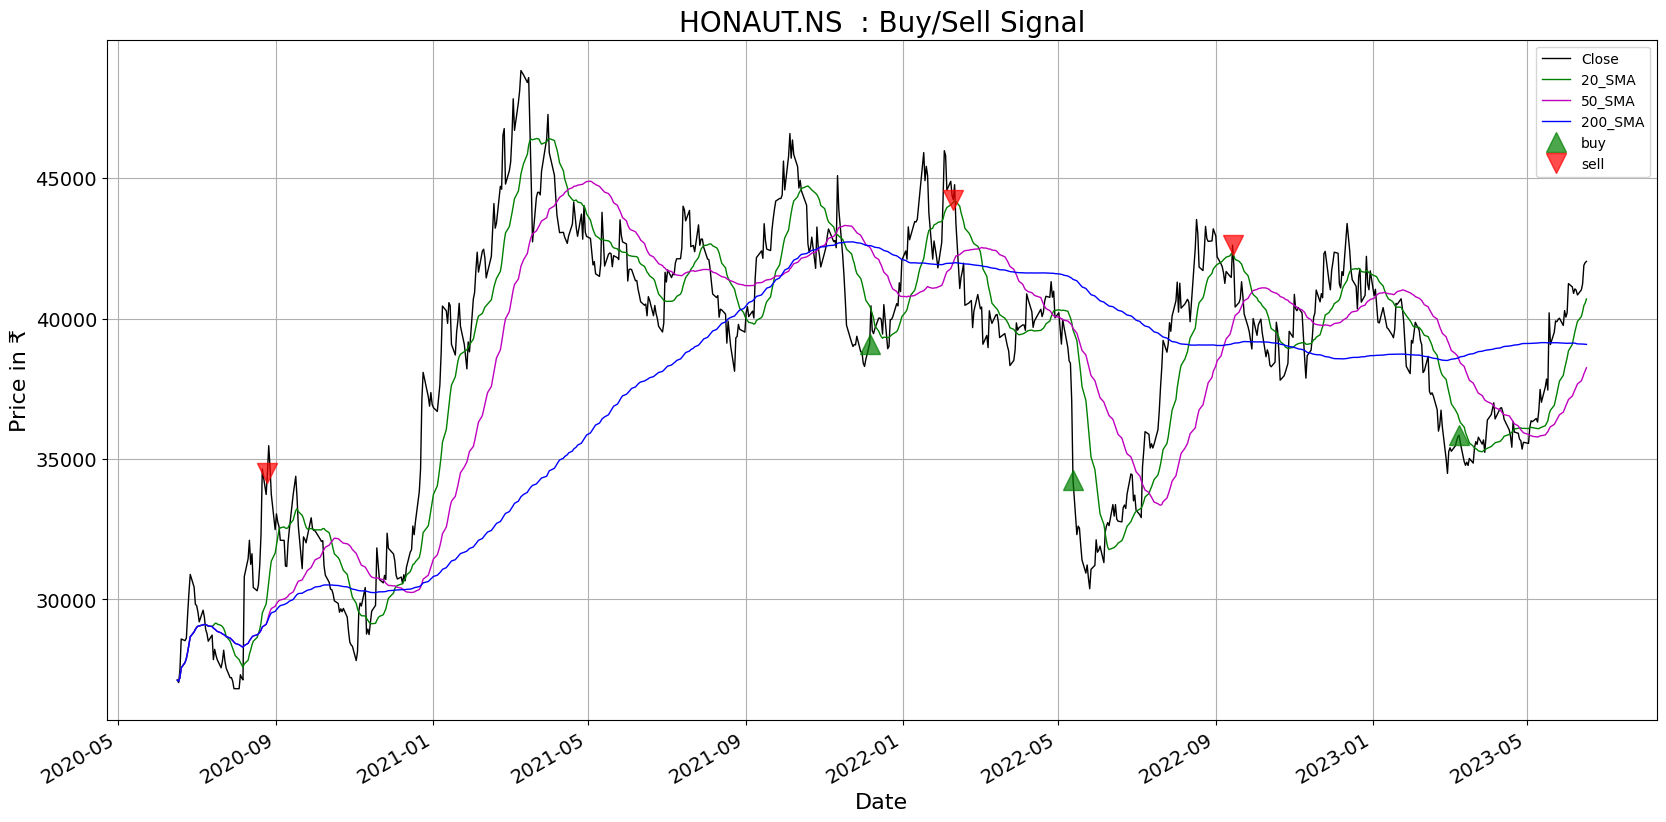

HONAUT.NS
+---------------------------+---------+----------+----------+-----------+-----------+------------+----------+------------+
| Date                      |   Close |   20_SMA |   50_SMA |   200_SMA | Stock     |   Dev%_200 |   Signal | Position   |
|---------------------------+---------+----------+----------+-----------+-----------+------------+----------+------------|
| 2020-08-25 00:00:00+05:30 |   34498 |    30200 |    29255 |     29213 | HONAUT.NS |      18.09 |       -1 | Sell       |
| 2021-12-06 00:00:00+05:30 |   39110 |    40451 |    42547 |     42602 | HONAUT.NS |      -8.2  |        1 | Buy        |
| 2022-02-09 00:00:00+05:30 |   44234 |    44142 |    42001 |     41984 | HONAUT.NS |       5.36 |       -1 | Sell       |
| 2022-05-13 00:00:00+05:30 |   34256 |    39601 |    39655 |     41399 | HONAUT.NS |     -17.25 |        1 | Buy        |
| 2022-09-14 00:00:00+05:30 |   42616 |    42322 |    39784 |     39110 | HONAUT.NS |       8.97 |       -1 | Sell       |
| 2023

In [8]:
stock_symbol = 'HONAUT.NS'
plot_stock_buy_sell(stock_symbol)